<h1>Hotel Booking Data Analysis: Cancellation Lead Time</h1>

Ideas for research question:

Looking at the data, 37% of hotel bookings got cancelled, therefore we will look into details:
- how many days in average usually people cancelled their reservation?
- does cancellation has any pattern related with the seasonality?

h0 hypothesis: mean of days cancelled reservations in all seasons are the same

h1 hypothesis: mean of days cancelled reservations differs in each season

p-value : 5%

variables that will be analyzed: is_canceled, arrival_date(year,month,week,day), lead_time, reservation_status_date

defining seasons:
- summer month = june, july, august
- fall month = september, october, november
- winter month = december, january, february
- spring month = march, april, may

benefit: hotel can better predict the capacity and last-minute marketing effort can be applied to attract more consumers in low seasons





In [78]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st

In [67]:
#load the data
df = pd.read_csv('hotel_bookings.csv')

In [91]:
#find out missing values within the data (all data)
cancel_df = df[df['is_canceled']==1]
print(f'There are {len(cancel_df)} of rows within the data before dropping duplicates')

#drop duplicate data
#cancel_df.drop_duplicates(inplace=True)
cancel_df = cancel_df[['adr','lead_time','arrival_date_year','arrival_date_month','arrival_date_week_number','arrival_date_day_of_month','reservation_status_date','reservation_status']]
print(f'There are {len(cancel_df)} of rows within the data')
row_nan_count = cancel_df.isna().sum(axis=0)
print(f'Total missing data in each column \n{row_nan_count}')


There are 44224 of rows within the data before dropping duplicates
There are 44224 of rows within the data
Total missing data in each column 
adr                          0
lead_time                    0
arrival_date_year            0
arrival_date_month           0
arrival_date_week_number     0
arrival_date_day_of_month    0
reservation_status_date      0
reservation_status           0
dtype: int64


In [92]:
#categorize the seasonality
def get_season(month):
    if month in ['December', 'January', 'February']:
        return 'Winter'
    elif month in ['March', 'April', 'May']:
        return 'Spring'
    elif month in ['June', 'July', 'August']:
        return 'Summer'
    else:
        return 'Fall'

cancel_df['season'] = cancel_df['arrival_date_month'].apply(get_season)
cancel_df.season.value_counts()

season
Summer    14516
Spring    12350
Fall      10484
Winter     6874
Name: count, dtype: int64

Text(0.5, 1.0, 'Distribution of Number Cancellations in each week')

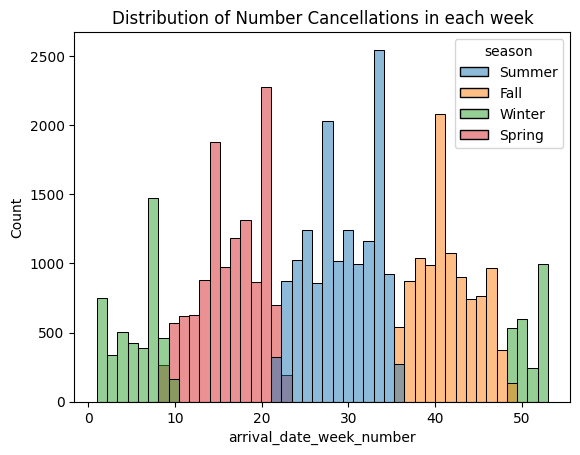

In [94]:
sns.histplot(data=cancel_df, x='arrival_date_week_number',hue='season')
plt.title('Distribution of Number Cancellations in each week')

Text(0.5, 1.0, 'Distribution of Price')

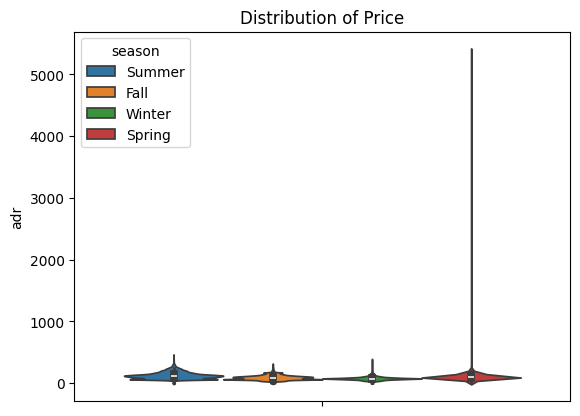

In [93]:
#from the data we can one outlier in term of pricing
sns.violinplot(data=cancel_df, y='adr',hue='season')
plt.title('Distribution of Price')

In [95]:
#preprocess the data to calculate cancellation lead time = (arrival_date - reservation_status_date)

#change into dateformat data
cancel_df['reservation_status_date'] = pd.to_datetime(cancel_df['reservation_status_date'])
cancel_df['arrival_date'] = pd.to_datetime(cancel_df['arrival_date_year'].astype(str) + '-' +
                                    cancel_df['arrival_date_month'].astype(str) + '-' +
                                    cancel_df['arrival_date_day_of_month'].astype(str))

#calculate cancellation lead time
cancel_df['cancellation_lead_time'] = cancel_df['lead_time'] - (cancel_df['arrival_date'] - cancel_df['reservation_status_date']).dt.days

cancel_df.head()


,adr,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,reservation_status_date,reservation_status,season,arrival_date,cancellation_lead_time
8,82.0,85,2015,July,27,1,2015-05-06,Canceled,Summer,2015-07-01,29
9,105.5,75,2015,July,27,1,2015-04-22,Canceled,Summer,2015-07-01,5
10,123.0,23,2015,July,27,1,2015-06-23,Canceled,Summer,2015-07-01,15
27,107.0,60,2015,July,27,1,2015-05-11,Canceled,Summer,2015-07-01,9
32,108.3,96,2015,July,27,1,2015-05-29,Canceled,Summer,2015-07-01,63


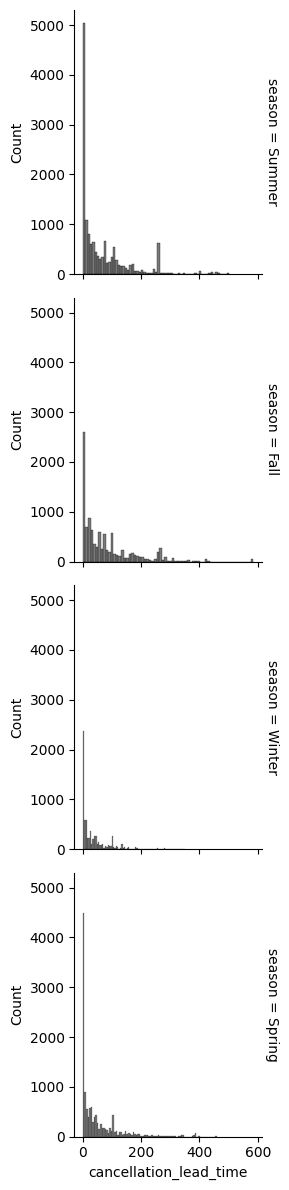

In [96]:
g = sns.FacetGrid(data=cancel_df, row="season", margin_titles=True)
g.map(sns.histplot, "cancellation_lead_time", color=".3")

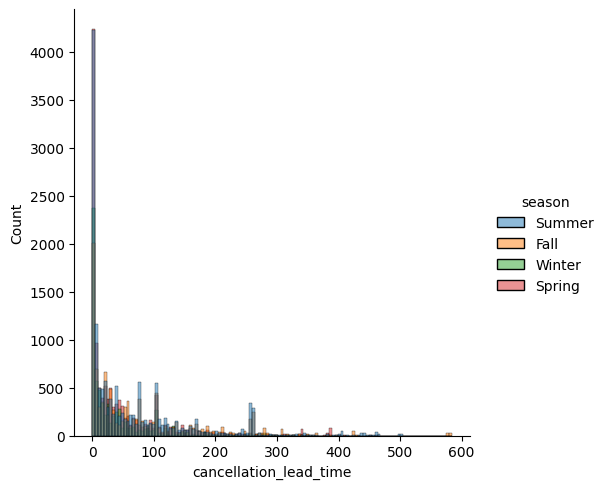

In [97]:
#check data distribution for cancellation lead time in each season, is it normally distributed or not

sns.displot(data=cancel_df, x='cancellation_lead_time', hue='season')

count    2.402500e+04
mean             -inf
std               NaN
min              -inf
25%      6.931472e-01
50%      2.564949e+00
75%      4.043051e+00
max      6.369901e+00
Name: log_cl, dtype: float64
Statistics=nan, p-value=1.0
Based on Shapiro-Wilk Test data is normally distributed
Statistics=0.6134045715289989, p-value=0.0
Based on Kolmogorov-Smirnov Test data is not normally distributed


/opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/opt/homebrew/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 24025.
  res = hypotest_fun_out(*samples, **kwds)
/opt/homebrew/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2842: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


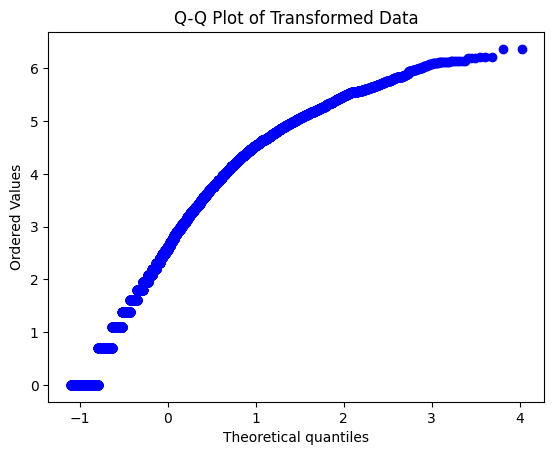

In [84]:
#all of the data is left-skewed, to be able to perform anova, data might need to be transformed first

#logarithmic transformation
cancel_df['log_cl']=np.log(cancel_df['cancellation_lead_time'])
print(cancel_df['log_cl'].describe())

#box-cox transformation
cancel_df['boxcox_cl'], _ = st.boxcox(cancel_df['cancellation_lead_time'])

#Shapiro-Wilk test
stat, p = st.shapiro(cancel_df['log_cl'])
print(f'Statistics={stat}, p-value={p}')

if p > 0.05:
    print('Based on Shapiro-Wilk Test data is normally distributed')
else:
    print('Based on Shapiro-Wilk Test data is not normally distributed')

# Kolmogorov-Smirnov test
stat, p = st.kstest(cancel_df['log_cl'], 'norm')
print(f'Statistics={stat}, p-value={p}')

if p > 0.05:
    print('Based on Kolmogorov-Smirnov Test data is normally distributed')
else:
    print('Based on Kolmogorov-Smirnov Test data is not normally distributed')

#Q-Q plot
st.probplot(cancel_df['log_cl'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Transformed Data')
plt.show()



In [ ]:
sns.displot(data=cancel_df, x='cancellation_lead_time', hue='season')

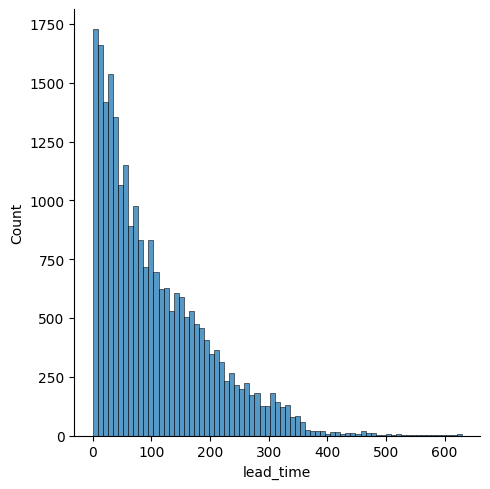

In [64]:
sns.displot(cancel_df, x='lead_time')

Statistics=0.9775624520488732, p-value=7.328503544695549e-58
Based on Shapiro-Wilk Test data is not normally distributed
Statistics=0.8151612560494684, p-value=0.0
Based on Kolmogorov-Smirnov Test data is not normally distributed


/var/folders/9f/klpz4yzx3hq9bcs22_drg0740000gn/T/ipykernel_34887/366594533.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['boxcox_cl'], _ = st.boxcox(data['cancellation_lead_time'])
/opt/homebrew/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 37054.
  res = hypotest_fun_out(*samples, **kwds)


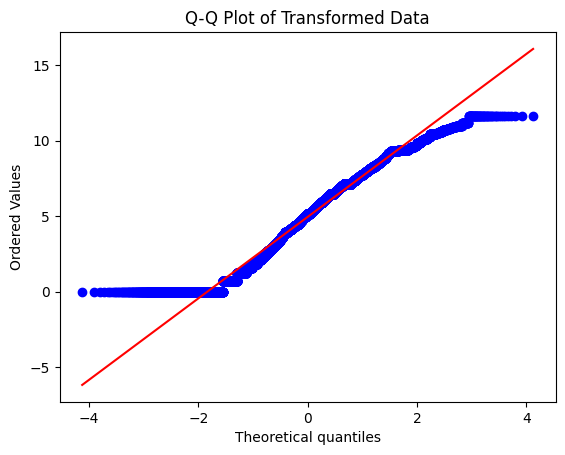

In [104]:
#all of the data is left-skewed, to be able to perform anova, data might need to be transformed first
data = cancel_df[cancel_df['cancellation_lead_time']>0]

#box-cox transformation
data['boxcox_cl'], _ = st.boxcox(data['cancellation_lead_time'])

#Shapiro-Wilk test
stat_sap, p_sap = st.shapiro(data['boxcox_cl'])
print(f'Statistics={stat_sap}, p-value={p_sap}')

if p_sap > 0.05:
    print('Based on Shapiro-Wilk Test data is normally distributed')
else:
    print('Based on Shapiro-Wilk Test data is not normally distributed')

# Kolmogorov-Smirnov test
stat, p = st.kstest(data['boxcox_cl'], 'norm')
print(f'Statistics={stat}, p-value={p}')

if p > 0.05:
    print('Based on Kolmogorov-Smirnov Test data is normally distributed')
else:
    print('Based on Kolmogorov-Smirnov Test data is not normally distributed')

#Q-Q plot
st.probplot(data['boxcox_cl'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Transformed Data BoxCox Data')
plt.show()



Statistics=0.9518636597812377, p-value=1.6809997681231448e-73
Based on Shapiro-Wilk Test data is not normally distributed
Statistics=0.7930848344719618, p-value=0.0
Based on Kolmogorov-Smirnov Test data is not normally distributed


/var/folders/9f/klpz4yzx3hq9bcs22_drg0740000gn/T/ipykernel_34887/4201323415.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['log_cl']= np.log(data['cancellation_lead_time'])
/opt/homebrew/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 37054.
  res = hypotest_fun_out(*samples, **kwds)


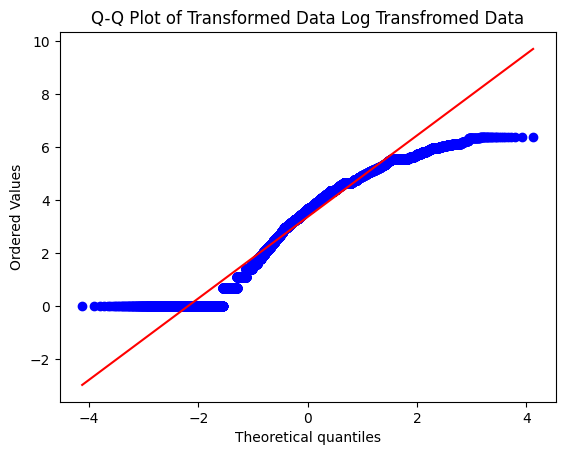

In [108]:
#all of the data is left-skewed, to be able to perform anova, data might need to be transformed first
# data = cancel_df[cancel_df['cancellation_lead_time']>0]

#box-cox transformation
data['log_cl']= np.log(data['cancellation_lead_time'])

#Shapiro-Wilk test
stat, p = st.shapiro(data['log_cl'])
print(f'Statistics={stat}, p-value={p}')

if p > 0.05:
    print('Based on Shapiro-Wilk Test data is normally distributed')
else:
    print('Based on Shapiro-Wilk Test data is not normally distributed')

# Kolmogorov-Smirnov test
stat, p = st.kstest(data['log_cl'], 'norm')
print(f'Statistics={stat}, p-value={p}')

if p > 0.05:
    print('Based on Kolmogorov-Smirnov Test data is normally distributed')
else:
    print('Based on Kolmogorov-Smirnov Test data is not normally distributed')

#Q-Q plot
st.probplot(data['log_cl'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Transformed Data Log Transfromed Data')
plt.show()



In [109]:
from scipy.stats import skew, kurtosis

#checking skewness, for normally distributed data skewness value 

print(f'Skewness Lead Time: {st.skew(cancel_df['lead_time'])}')
print(f'Skewness Cancellation Lead Time: {st.skew(cancel_df['cancellation_lead_time'])}')
print(f'Skewness Cancellation Lead Time > 0: {st.skew(data['cancellation_lead_time'])}')
print(f'Skewness Cancellation Lead Time Log: {st.skew(data['log_cl'])}')
print(f'Skewness Cancellation Lead Time BoxCox: {st.skew(data['boxcox_cl'])}')

Skewness Lead Time: 1.0317484180590757
Skewness Cancellation Lead Time: 2.223126152183375
Skewness Cancellation Lead Time > 0: 2.0441448486494993
Skewness Cancellation Lead Time Log: -0.5429937786900407
Skewness Cancellation Lead Time BoxCox: -0.0821411077309889


In [110]:
from scipy.stats import skew, kurtosis

#checking skewness, for normally distributed data skewness value 

print(f'Kurtosis Lead Time: {st.kurtosis(cancel_df['lead_time'])}')
print(f'Kurtosis Cancellation Lead Time: {st.kurtosis(cancel_df['cancellation_lead_time'])}')
print(f'Kurtosis Cancellation Lead Time > 0: {st.kurtosis(data['cancellation_lead_time'])}')
print(f'Kurtosis Cancellation Lead Time Log: {st.kurtosis(data['log_cl'])}')
print(f'Kurtosis Cancellation Lead Time BoxCox: {st.kurtosis(data['boxcox_cl'])}')

Kurtosis Lead Time: 0.7768283733528096
Kurtosis Cancellation Lead Time: 6.083452703798221
Kurtosis Cancellation Lead Time > 0: 5.151187757669714
Kurtosis Cancellation Lead Time Log: -0.5755437418368565
Kurtosis Cancellation Lead Time BoxCox: -0.8311307233407721


After performing statistical analysis
conclusion: not possible to perform the analysis since the data is not normally distributed

<H1>Hotel Booking Analysis: Price per Night</H1>



,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [112]:
df.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

<Axes: xlabel='adr'>

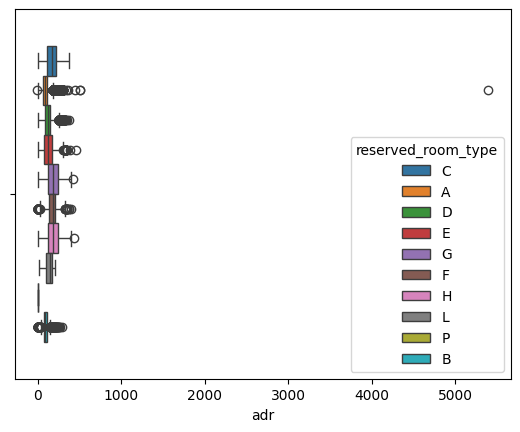

In [115]:
sns.boxplot(data=df, hue='reserved_room_type', x='adr')

<Axes: xlabel='adr'>

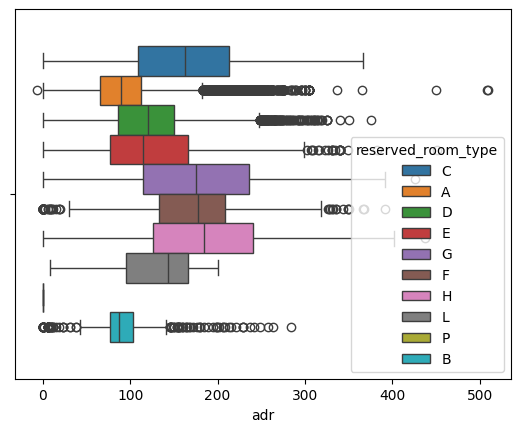

In [116]:
#remove outlier
df = df[df['adr']<5000]
sns.boxplot(data=df, hue='reserved_room_type', x='adr')

<Axes: xlabel='adr', ylabel='Count'>

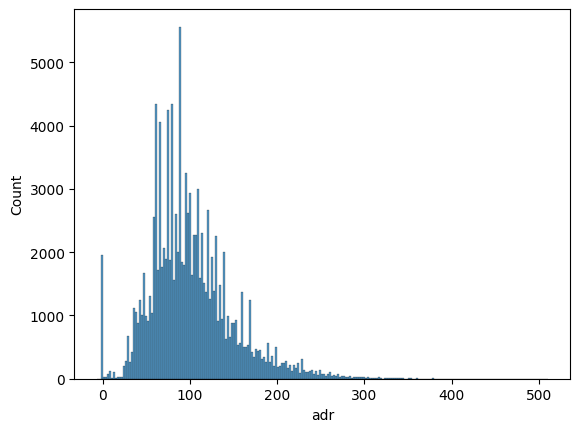

In [118]:
sns.histplot(data=df, x='adr')

In [121]:
#Shapiro-Wilk test
stat, p = st.shapiro(df['adr'])
print(f'Statistics={stat}, p-value={p}')

if p > 0.05:
    print('Based on Shapiro-Wilk Test data is normally distributed')
else:
    print('Based on Shapiro-Wilk Test data is not normally distributed')


Statistics=0.9470682684454259, p-value=4.841904671066661e-99
Based on Shapiro-Wilk Test data is not normally distributed


In [126]:
for col in df.columns:
    if isinstance(df[col], (int, float)):
        stat, p = st.shapiro(df[col])
        print(f'Column: {col}, Statistics={stat}, p-value={p}')
        
        if p > 0.05:
            print('Based on Shapiro-Wilk Test data is normally distributed')
        else:
            print('Based on Shapiro-Wilk Test data is not normally distributed')

In [129]:
#categorize the seasonality
def get_season(month):
    if month in ['December', 'January', 'February']:
        return 'Winter'
    elif month in ['March', 'April', 'May']:
        return 'Spring'
    elif month in ['June', 'July', 'August']:
        return 'Summer'
    else:
        return 'Fall'

data['season'] = data['arrival_date_month'].apply(get_season)
data.season.value_counts()

/var/folders/9f/klpz4yzx3hq9bcs22_drg0740000gn/T/ipykernel_34887/2698453784.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['season'] = data['arrival_date_month'].apply(get_season)


season
Summer    12340
Spring     9646
Fall       9483
Winter     5585
Name: count, dtype: int64

<Axes: xlabel='adr'>

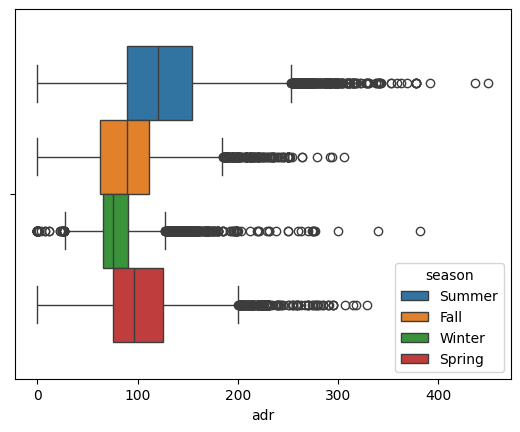

In [132]:
sns.boxplot(data=data, x='adr', hue='season')

In [134]:
df.iloc[400]

hotel                              Resort Hotel
is_canceled                                   1
lead_time                                    96
arrival_date_year                          2015
arrival_date_month                         July
arrival_date_week_number                     29
arrival_date_day_of_month                    14
stays_in_weekend_nights                       2
stays_in_week_nights                          7
adults                                        2
children                                    0.0
babies                                        0
meal                                         BB
country                                     PRT
market_segment                    Offline TA/TO
distribution_channel                      TA/TO
is_repeated_guest                             0
previous_cancellations                        0
previous_bookings_not_canceled                0
reserved_room_type                            A
assigned_room_type                      

In [139]:
sns.boxplot(data=df, x='adr', hue='stays_in_weekday_nights')

ValueError: Could not interpret value `stays_in_weekday_nights` for `hue`. An entry with this name does not appear in `data`.

<Axes: xlabel='booking_changes', ylabel='Count'>

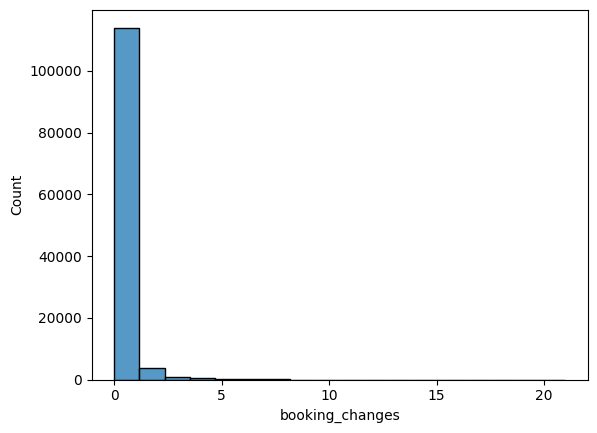

In [137]:
sns.histplot(data=df, x='booking_changes')